In [14]:
pip install requests 

In [15]:
pip install  schedule 


In [17]:
 pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [71]:
# Real-Time Data Processing System for Weather Monitoring

## Step 1: Importing Libraries
#python
import requests
import sqlite3
import matplotlib.pyplot as plt
import datetime
import schedule
import time


In [72]:
API_KEY = '9fb255b1ec732f0f5651fb7d34866d0e'  # Replace with your actual API key
CITIES = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']
BASE_URL = "http://api.openweathermap.org/data/2.5/weather"


In [73]:
def fetch_weather_data(city):
    params = {'q': city, 'appid': API_KEY}
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        return {
            'city': city,
            'temperature': data['main']['temp'] - 273.15,  # Convert to Celsius
            'feels_like': data['main']['feels_like'] - 273.15,
            'weather_condition': data['weather'][0]['main'],
            'timestamp': data['dt']  # Unix timestamp
        }
    else:
        print(f"Failed to fetch data for {city}")
        return None


In [74]:
conn = sqlite3.connect('weather.db')

def create_tables():
    conn.execute('''CREATE TABLE IF NOT EXISTS weather
                    (city TEXT, temperature REAL, feels_like REAL, weather_condition TEXT, timestamp INT)''')
    conn.execute('''CREATE TABLE IF NOT EXISTS daily_summary
                    (city TEXT, date TEXT, avg_temp REAL, max_temp REAL, min_temp REAL, dominant_condition TEXT)''')
    conn.commit()

create_tables()


In [75]:
def insert_weather_data(data):
    conn.execute("INSERT INTO weather VALUES (?, ?, ?, ?, ?)", 
                 (data['city'], data['temperature'], data['feels_like'], data['weather_condition'], data['timestamp']))
    conn.commit()

# Fetch data for all cities and store it
for city in CITIES:
    weather_data = fetch_weather_data(city)
    if weather_data:
        insert_weather_data(weather_data)


In [76]:
def calculate_daily_summary():
    date_today = datetime.datetime.now().strftime('%Y-%m-%d')
    for city in CITIES:
        query = f"SELECT temperature, weather_condition FROM weather WHERE city='{city}' AND date(timestamp, 'unixepoch')='{date_today}'"
        rows = conn.execute(query).fetchall()
        if rows:
            temps = [row[0] for row in rows]
            weather_conditions = [row[1] for row in rows]
            avg_temp = sum(temps) / len(temps)
            max_temp = max(temps)
            min_temp = min(temps)
            dominant_condition = max(set(weather_conditions), key=weather_conditions.count)
            conn.execute("INSERT INTO daily_summary VALUES (?, ?, ?, ?, ?, ?)",
                         (city, date_today, avg_temp, max_temp, min_temp, dominant_condition))
            conn.commit()

calculate_daily_summary()


In [77]:
ALERT_THRESHOLD = 35.0  

def check_threshold(city, temperature):
    if temperature > ALERT_THRESHOLD:
        print(f"Alert! {city} has exceeded the temperature threshold with {temperature}°C.")

# Simulate fetching weather data and triggering alerts
for city in CITIES:
    weather_data = fetch_weather_data(city)
    if weather_data:
        check_threshold(city, weather_data['temperature'])


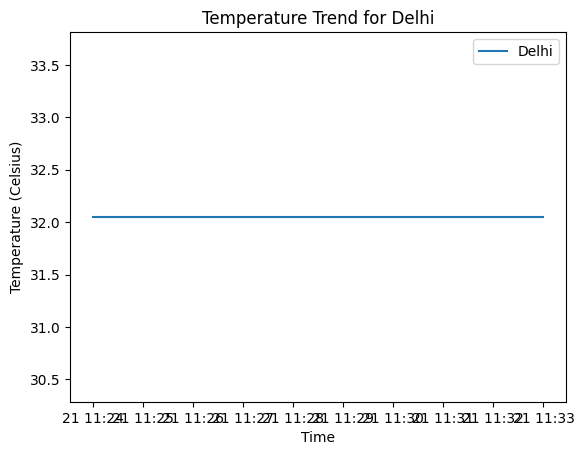

In [78]:
def plot_weather_trend(city):
    query = f"SELECT timestamp, temperature FROM weather WHERE city='{city}'"
    rows = conn.execute(query).fetchall()
    if rows:
        timestamps = [datetime.datetime.utcfromtimestamp(row[0]) for row in rows]
        temps = [row[1] for row in rows]
        plt.plot(timestamps, temps, label=f'{city}')
        plt.title(f"Temperature Trend for {city}")
        plt.xlabel('Time')
        plt.ylabel('Temperature (Celsius)')
        plt.legend()
        plt.show()

# Plot data for a specific city
plot_weather_trend('Delhi')


In [79]:
def job():
    for city in CITIES:
        weather_data = fetch_weather_data(city)
        if weather_data:
            insert_weather_data(weather_data)
    calculate_daily_summary()

# Schedule the job to run every 5 minutes (or manually trigger it)
schedule.every(5).minutes.do(job)

# For demonstration, run it once manually
job()
